# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is to identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image.

This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".

## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


Point a variable to the path where the data resides. Note that to use the code below you will need to move the folders effusion/ and nofinding/ into one common folder. You can do something like this:

```
mkdir CXR_Data
move effusion CXR_Data
move nofinding CXR_Data
```

In [2]:
DATASET_PATH = './CXR_data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

Next, we read the "effusion" and "nofinding" images.

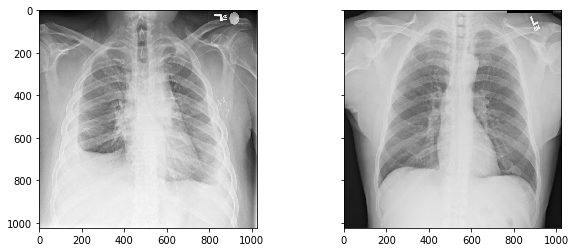

In [8]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

# axes[0].imshow(effusion)
# axes[1].imshow(normal)

In [4]:
effusion.shape

(1024, 1024)

In [5]:
normal.shape

(1024, 1024)

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation. We use the concept of a "data generator" that you learnt in the last section.

In [5]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max() - img.min())
    img = rescale(img, 0.25, multichannel=True, mode='constant')
    
    if mode == 'train':
        if np.random.randn() > 0:
            img = datagen.random_transform(img)
    return img

## 2. Model building

We will be using a Resnet in this (you learnt about Resnets previously). 

For this to work, the script that defines the resnet model (resnet.py) should reside in the same folder as this notebook

In [6]:
import resnet

img_channels = 1
img_rows = 256
img_cols = 256

nb_classes = 2

In [7]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
                
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

## 3. Ablation Run

In the previous notebook, you learnt about Ablation. Briefly, an ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1)

Epoch 1/1


In [12]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=5)

Epoch 1/5
1/1 [==============================] - 27s 27s/step - loss: 1.6028 - acc: 0.6774
Epoch 2/5
1/1 [==============================] - 20s 20s/step - loss: 1.4025 - acc: 0.9355
Epoch 3/5
1/1 [==============================] - 18s 18s/step - loss: 1.3118 - acc: 0.9375
Epoch 4/5
1/1 [==============================] - 18s 18s/step - loss: 1.3676 - acc: 0.8710
Epoch 5/5
1/1 [==============================] - 30s 30s/step - loss: 1.3479 - acc: 0.8710


In [9]:
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [19]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy',optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=5, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - 127s 25s/step - loss: 1.4078 - acc: 0.8642 - val_loss: 1.2881 - val_acc: 0.9062

Val AUC for epoch0: 0.5892857142857142
Epoch 2/5
5/5 [==============================] - 117s 23s/step - loss: 1.3062 - acc: 0.8961 - val_loss: 1.3359 - val_acc: 0.8750

Val AUC for epoch1: 0.5747126436781609
Epoch 3/5
5/5 [==============================] - 116s 23s/step - loss: 1.2857 - acc: 0.8961 - val_loss: 1.2711 - val_acc: 0.9062

Val AUC for epoch2: 0.5357142857142858
Epoch 4/5
5/5 [==============================] - 112s 22s/step - loss: 1.2595 - acc: 0.9100 - val_loss: 1.3443 - val_acc: 0.8750

Val AUC for epoch3: 0.31666666666666665
Epoch 5/5
5/5 [==============================] - 100s 20s/step - loss: 1.2669 - acc: 0.9031 - val_loss: 1.2130 - val_acc: 0.9375

Val AUC for epoch4: 0.19354838709677422


In [21]:
from functools import partial
import keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis=1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] * y_pred_max_mat[:, c_p] * y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits=False)
    return cross_ent * final_mask

bin_weights = np.ones((2,2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

In [22]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss=ncce, optimizer='SGD',
              metrics=['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation=5)
validation_generator = AugmentedDataGenerator('val', ablation=5)

model.fit_generator(generator=training_generator,
                    validation_data=None,
                    epochs=1)

Epoch 1/1
1/1 [==============================] - 30s 30s/step - loss: 3.8399 - acc: 0.3226


## 4. Final Run

After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [14]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [23]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizers.SGD(lr=0.005)

bin_weights = np.ones((2,2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights=bin_weights)
ncce.__name__ ='w_categorical_crossentropy'

model.compile(loss=ncce,optimizer= sgd,
              metrics=['accuracy'])
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')

decay = DecayLR()

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=10, callbacks=[auc_logger, decay, checkpoint])

Epoch 1/10
13/13 [==============================] - 329s 25s/step - loss: 2.2982 - acc: 0.5948 - val_loss: 2.3582 - val_acc: 0.8854

Val AUC for epoch0: 0.5913154533844189

Epoch 00001: val_auc improved from -inf to 0.59132, saving model to models/best_model.hdf5
Epoch 2/10
13/13 [==============================] - 274s 21s/step - loss: 2.2100 - acc: 0.6119 - val_loss: 2.1747 - val_acc: 0.4167

Val AUC for epoch1: 0.7203065134099618

Epoch 00002: val_auc improved from 0.59132 to 0.72031, saving model to models/best_model.hdf5
Epoch 3/10
13/13 [==============================] - 266s 20s/step - loss: 2.2287 - acc: 0.5144 - val_loss: 2.1648 - val_acc: 0.5833

Val AUC for epoch2: 0.7867177522349935

Epoch 00003: val_auc improved from 0.72031 to 0.78672, saving model to models/best_model.hdf5
Epoch 4/10
13/13 [==============================] - 266s 20s/step - loss: 2.1625 - acc: 0.6251 - val_loss: 2.1346 - val_acc: 0.5625

Val AUC for epoch3: 0.7802325581395348

Epoch 00004: val_auc did not 

## 5. Making a Prediction

In [38]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')

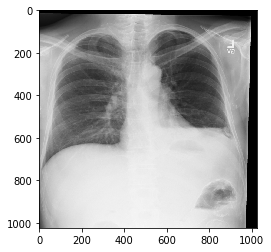

In [55]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[-8])
plt.imshow(effusion,cmap='gray')

In [56]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis,:])

array([[0.36457857, 0.63542145]], dtype=float32)